In [1]:
from utils import *

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

In [2]:
location = os.path.join("checkpoints", "PCAFormer")
config = Config().load(os.path.join(location, "config.json"))

In [3]:
if "cacheDir" in config:
    os.environ["KAGGLEHUB_CACHE"] = config.cacheDir

dataDir = download_dataset("dimensi0n/imagenet-256")

config.dataset.dataDir = dataDir

KaggleHub dataset path: F:/.cache/kagglehub\datasets\dimensi0n\imagenet-256\versions\1


In [4]:
def loadPCA(x):
    pcaFormer = PCAFormer(config.model)
    pcaFormer.load_state_dict(torch.load(os.path.join(location, "checkpoint.pt")))
    return pcaFormer

loadResNet = lambda x: resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
loadSwin = lambda x: swin_v2_t(weights=Swin_V2_T_Weights.IMAGENET1K_V1)
loadVIT = lambda x: vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

modelLoaders = [loadPCA, loadResNet, loadSwin, loadVIT]
transforms = [None, ResNet50_Weights.IMAGENET1K_V1.transforms(), Swin_V2_T_Weights.IMAGENET1K_V1.transforms(),
              ViT_B_16_Weights.IMAGENET1K_V1.transforms()]
modelNames = ["PCAFormer", "ResNet50", "SwinTransformer-Tiny", "ViT-Base-16"]

In [5]:
def getAttentionMatrices(m):
    attentionMatrices = {}

    def captureAttention(name):
        def hook(module, input, output):
            if m == 3:
                attnModule = module.self_attention
                x = input[0]
                q = k = v = x
                _, attn = attnModule(q, k, v, need_weights=True)
                attentionMatrices[name] = attn
            else:
                attnModule = module.attn
                print(name)
                x = module.lastPCA
                x = module.ln1(x)
                q = k = v = x
                _, attn = attnModule(q, k, v, need_weights=True)
                attentionMatrices[name] = attn

        return hook

    loaders = get_dataloaders(config, device, transforms[m])
    currentModel = modelLoaders[m](None)
    handles = []
    if m == 3:
        for i, block in enumerate(currentModel.encoder.layers):
            hookHandle = block.register_forward_hook(captureAttention(f"layer_{i}"))
            handles.append(hookHandle)
    else:
        for i, block in enumerate(currentModel.transformer.children()):
            hookHandle = block.register_forward_hook(captureAttention(f"layer_{i}"))
            handles.append(hookHandle)

    inputs = next(iter(loaders["val"]))[0][4, :, :, :].unsqueeze(0).to(device)
    print(inputs.shape)

    with torch.no_grad():
        _ = currentModel(inputs)

    for handle in handles:
        handle.remove()

    return inputs, attentionMatrices

In [6]:
inputs, vitMatrices = getAttentionMatrices(3)

torch.Size([1, 3, 224, 224])


In [7]:
inputs, pcaMatrices = getAttentionMatrices(0)

torch.Size([1, 3, 256, 256])
layer_0
layer_1
layer_2
layer_3
layer_4
layer_5
layer_6
layer_7
layer_8
layer_9
layer_10
layer_11


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


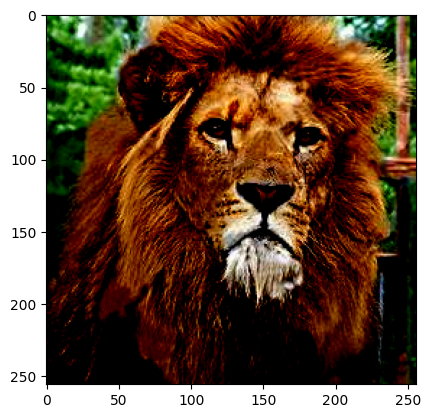

layer_0 torch.Size([1, 197, 197])


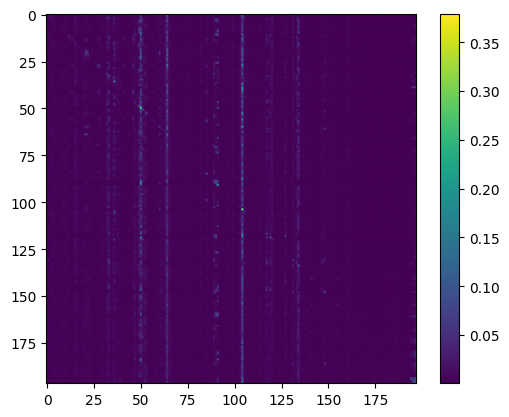

layer_1 torch.Size([1, 197, 197])


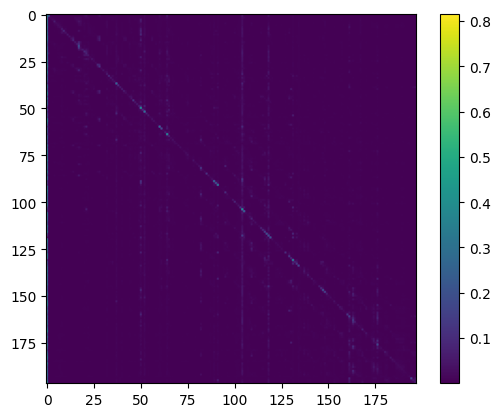

layer_2 torch.Size([1, 197, 197])


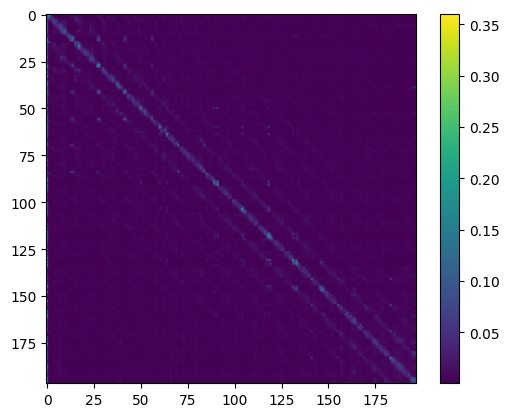

layer_3 torch.Size([1, 197, 197])


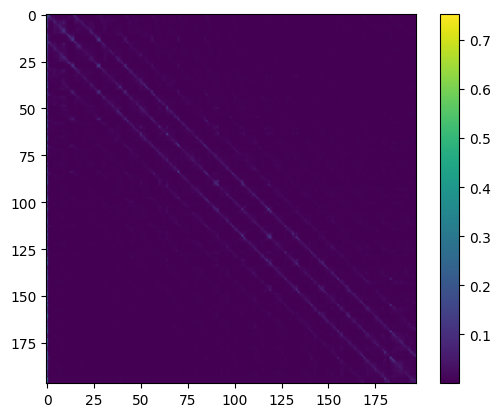

layer_4 torch.Size([1, 197, 197])


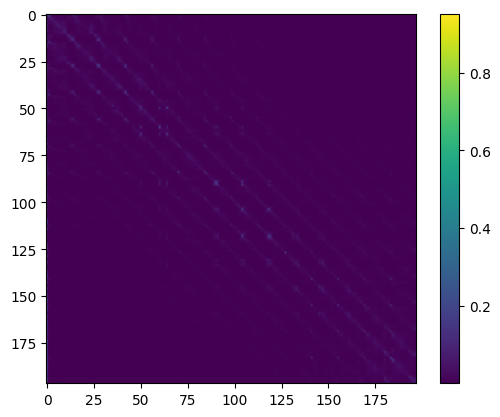

layer_5 torch.Size([1, 197, 197])


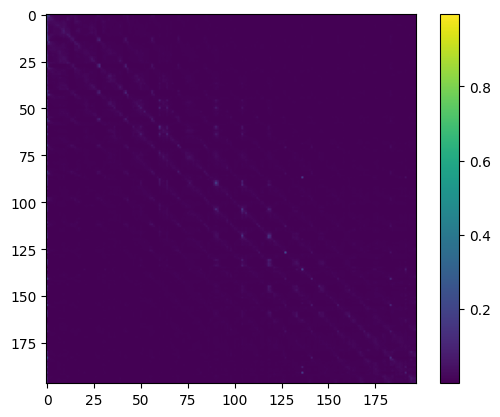

layer_6 torch.Size([1, 197, 197])


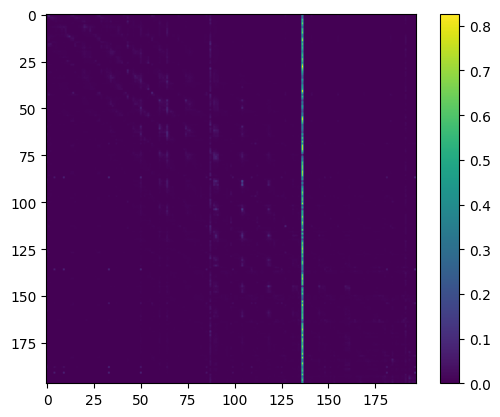

layer_7 torch.Size([1, 197, 197])


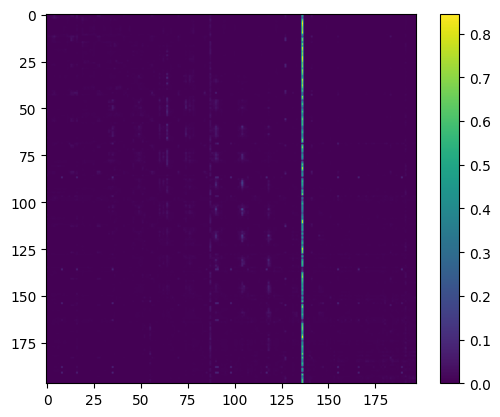

layer_8 torch.Size([1, 197, 197])


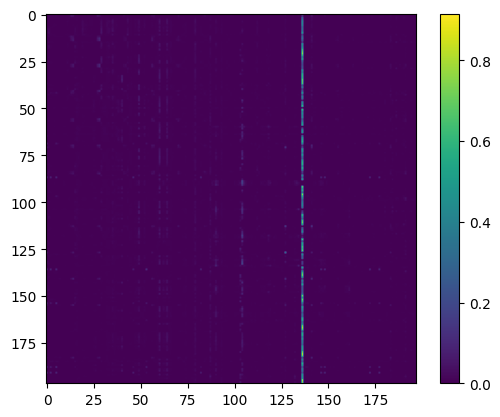

layer_9 torch.Size([1, 197, 197])


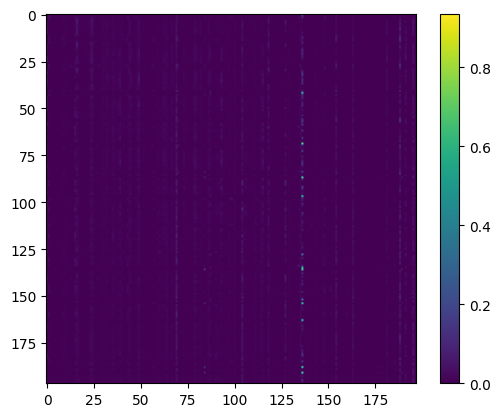

layer_10 torch.Size([1, 197, 197])


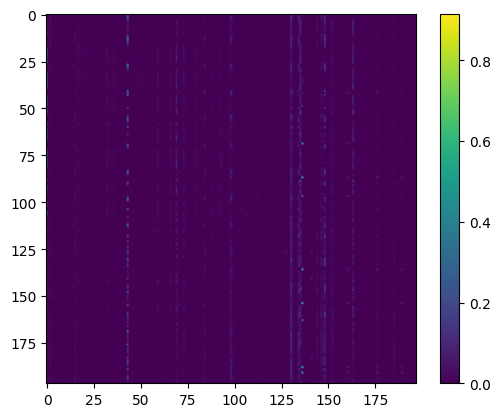

layer_11 torch.Size([1, 197, 197])


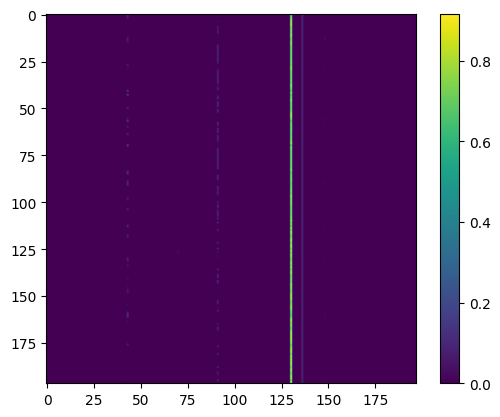

layer_0 torch.Size([1, 257, 257])


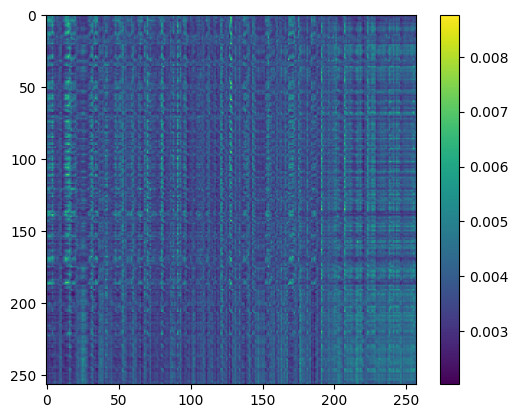

layer_1 torch.Size([1, 129, 129])


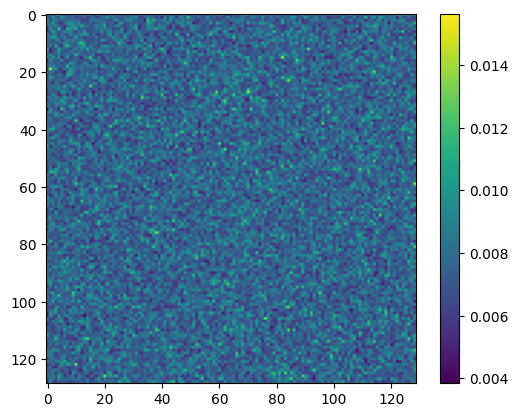

layer_2 torch.Size([1, 129, 129])


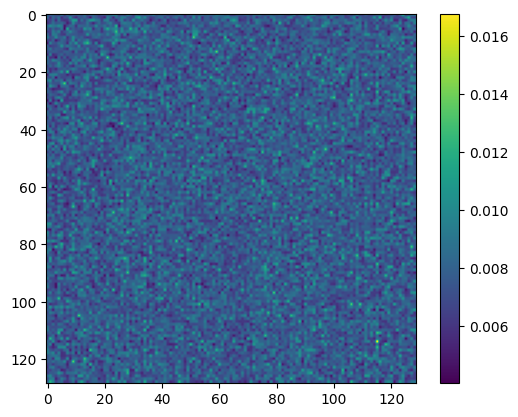

layer_3 torch.Size([1, 65, 65])


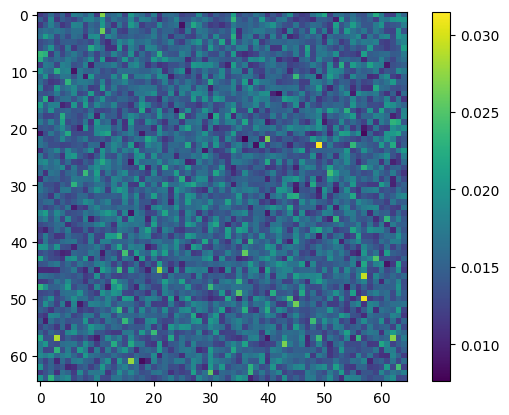

layer_4 torch.Size([1, 65, 65])


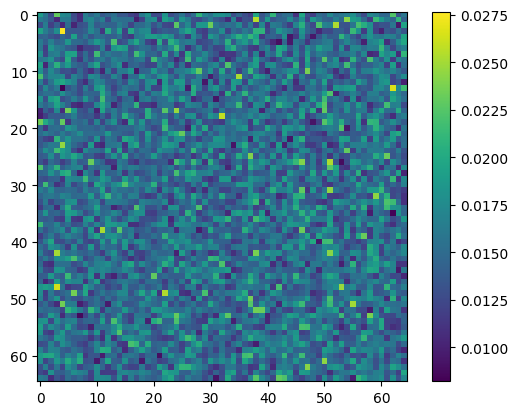

layer_5 torch.Size([1, 33, 33])


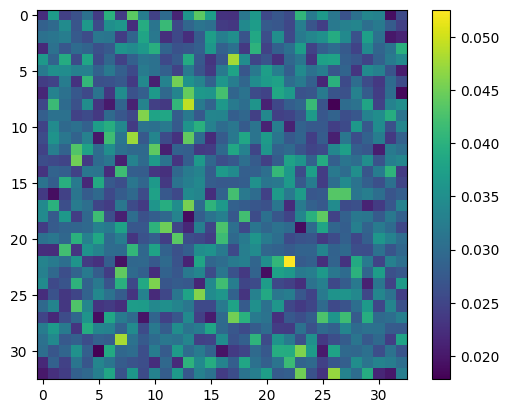

layer_6 torch.Size([1, 33, 33])


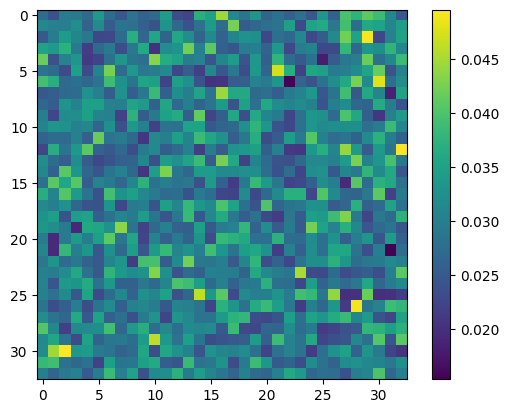

layer_7 torch.Size([1, 17, 17])


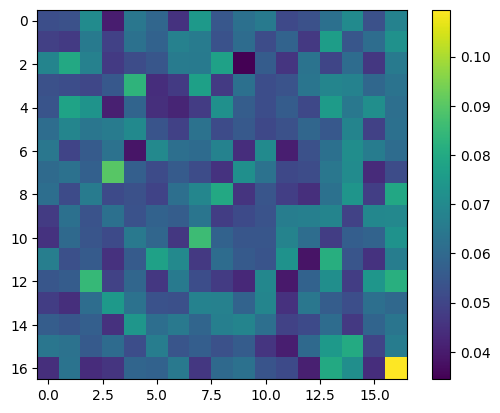

layer_8 torch.Size([1, 17, 17])


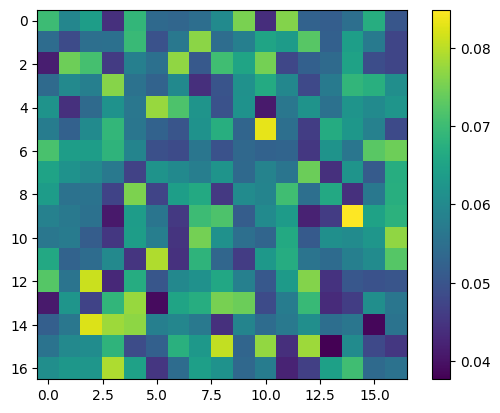

layer_9 torch.Size([1, 9, 9])


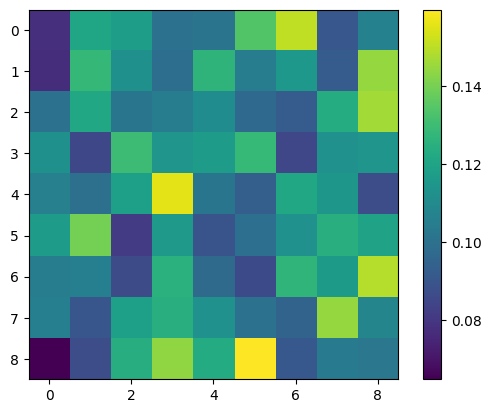

layer_10 torch.Size([1, 9, 9])


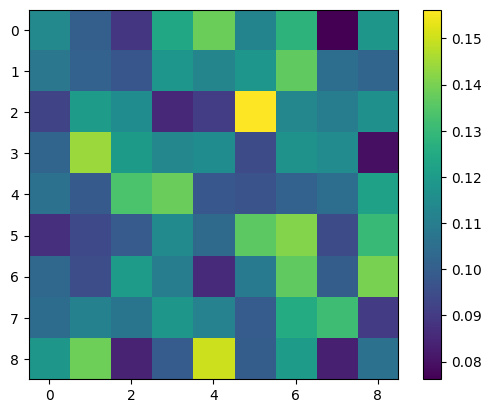

layer_11 torch.Size([1, 5, 5])


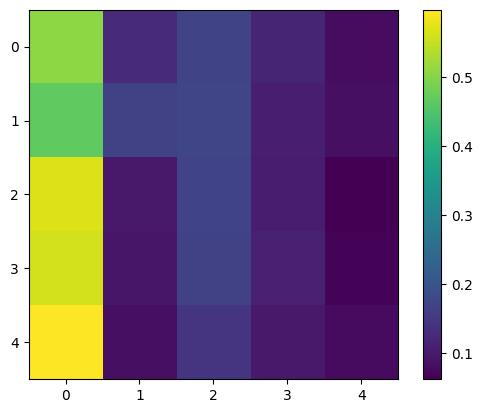

In [8]:
plt.imshow(inputs.squeeze().permute(1, 2, 0).cpu())
plt.show()
for key, value in vitMatrices.items():
    print(key, value.shape)
    plt.imshow(value.squeeze().cpu())
    plt.colorbar()
    plt.show()

for key, value in pcaMatrices.items():
    print(key, value.shape)
    plt.imshow(value.squeeze().cpu())
    plt.colorbar()
    plt.show()